In [4]:
# Q3_PoissonRegression.ipynb

import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_poisson_deviance
)

import matplotlib.pyplot as plt

# 1) Load pre-split data and preprocessing pipeline

X_train = joblib.load("X_train.pkl")
X_test  = joblib.load("X_test.pkl")
y_train = joblib.load("y_train.pkl")
y_test  = joblib.load("y_test.pkl")

preprocess = joblib.load("preprocess_pipeline.pkl")

# 2) Poisson Regression model (baseline)
poisson_model = Pipeline([
    ("preprocess", preprocess),
    ("model", PoissonRegressor(alpha=0.0001, max_iter=500))
])

poisson_model.fit(X_train, y_train)

# Sample predictions
y_pred_poisson_test = poisson_model.predict(X_test)

print("First 10 predictions:", y_pred_poisson_test[:10])
print("First 10 actuals:    ", y_test[:10].values)


# 3) Train/Test metrics

y_pred_poisson_train = poisson_model.predict(X_train)
y_pred_poisson_test  = poisson_model.predict(X_test)

# Train metrics
rmse_poisson_train = np.sqrt(mean_squared_error(y_train, y_pred_poisson_train))
mae_poisson_train  = mean_absolute_error(y_train, y_pred_poisson_train)

# Test metrics
rmse_poisson_test = np.sqrt(mean_squared_error(y_test, y_pred_poisson_test))
mae_poisson_test  = mean_absolute_error(y_test, y_pred_poisson_test)

# Deviance in test
pdev_poisson_test = mean_poisson_deviance(
    y_test,
    np.maximum(y_pred_poisson_test, 1e-8)
)

print("Poisson Train RMSE:", rmse_poisson_train)
print("Poisson Train MAE :", mae_poisson_train)
print("Poisson Test RMSE:", rmse_poisson_test)
print("Poisson Test MAE :", mae_poisson_test)
print("Poisson Test Deviance:", pdev_poisson_test)

metrics_poisson = {
    "Model": "Poisson Regression",
    "RMSE_train": rmse_poisson_train,
    "RMSE_test": rmse_poisson_test,
    "MAE_train": mae_poisson_train,
    "MAE_test": mae_poisson_test,
    "Deviance_test": pdev_poisson_test
}

metrics_poisson


First 10 predictions: [1.15826252 1.34545041 2.01006908 1.11611641 1.06969936 0.83899744
 1.03228714 2.1597122  4.27078325 1.38308486]
First 10 actuals:     [0 1 1 0 1 0 0 4 8 4]
Poisson Train RMSE: 2.666782823648204
Poisson Train MAE : 1.091620248956936
Poisson Test RMSE: 1.9840233935418796
Poisson Test MAE : 1.0941415688407734
Poisson Test Deviance: 1.3326611312990526


{'Model': 'Poisson Regression',
 'RMSE_train': np.float64(2.666782823648204),
 'RMSE_test': np.float64(1.9840233935418796),
 'MAE_train': 1.091620248956936,
 'MAE_test': 1.0941415688407734,
 'Deviance_test': 1.3326611312990526}

In [5]:
# 4) Feature names after preprocessing
preprocessor = poisson_model.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()

print("Total transformed features:", len(feature_names))

# 5) Poisson 'feature importances' using coefficients
pois_est = poisson_model.named_steps["model"]   
coeffs   = pois_est.coef_                      

poisson_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coeffs,
    "importance": np.abs(coeffs)
}).sort_values("importance", ascending=False)

print("\nTop 20 Poisson coefficients (by |coef|):")
print(poisson_df.head(20))


Total transformed features: 79

Top 20 Poisson coefficients (by |coef|):
                           feature      coef  importance
6            num__visits_last_year  0.414747    0.414747
18                 num__risk_score  0.231238    0.231238
64             cat__smoker_Current -0.172101    0.172101
1                         num__age -0.148336    0.148336
21           num__avg_claim_amount  0.107405    0.107405
19        num__annual_medical_cost -0.065890    0.065890
61  cat__employment_status_Retired -0.053861    0.053861
73              cat__plan_type_POS -0.053671    0.053671
42             cat__region_Central -0.051675    0.051675
65              cat__smoker_Former  0.051574    0.051574
66               cat__smoker_Never  0.047234    0.047234
22              num__chronic_count  0.043540    0.043540
67         cat__alcohol_freq_Daily -0.034207    0.034207
51        cat__education_Doctorate -0.031745    0.031745
58      cat__marital_status_Single -0.030835    0.030835
5              

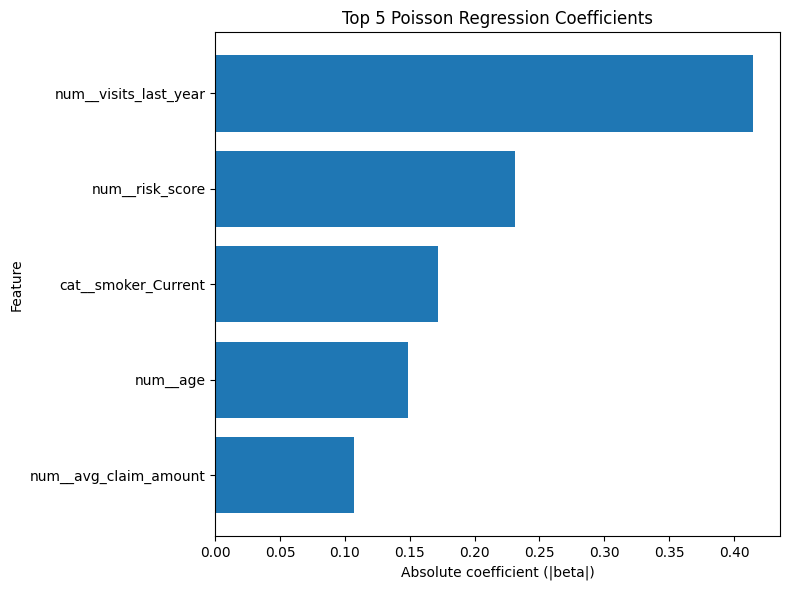

In [6]:
# 6) Barplot – Top N features (Poisson)

top_n = 5
top_pois = poisson_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_pois["feature"][::-1], top_pois["importance"][::-1])
plt.xlabel("Absolute coefficient (|beta|)")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Poisson Regression Coefficients")
plt.tight_layout()
plt.show()
